In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
data = pd.read_csv("spain_energy_market.csv")
data['datetime'] = pd.to_datetime(data['datetime'].str.slice(0,10))
data.head()
data_forecast = data[['datetime','geoname', 'value']]
data_forecast.head()
for i,d in data_forecast.groupby(['geoname']):
    d.to_csv(f'split_Data/{i}.csv')

In [15]:
data_espana = pd.read_csv("split_Data/España.csv")

In [16]:
data_espana.index = pd.to_datetime(data_espana['datetime'])
data_espana = pd.DataFrame(data_espana['value'])
data_espana.head()

,value
datetime,
2014-01-01,25.280833
2014-01-02,39.924167
2014-01-03,4.992083
2014-01-04,4.091667
2014-01-05,13.587500


<AxesSubplot:xlabel='datetime'>

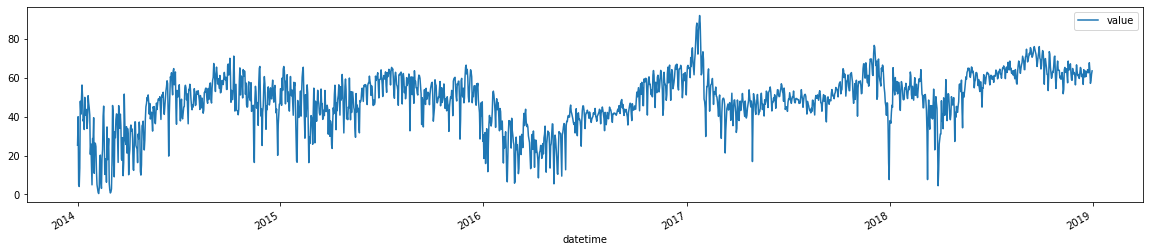

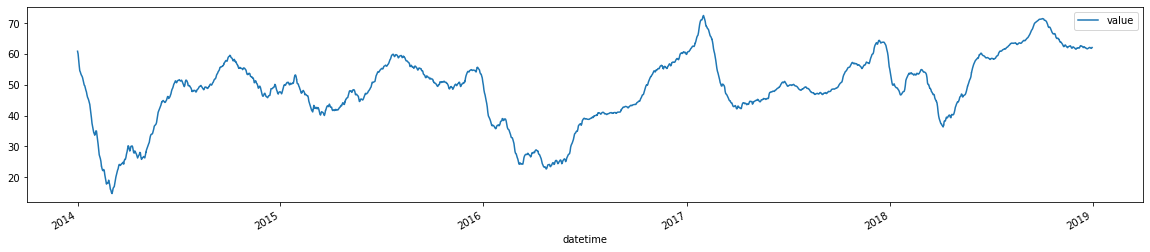

In [38]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from  statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
#trying to minimise noise for better result 
data_nn = data_espana.rolling(window=30).mean()[30:]
data_espana.plot(figsize=(20,4))
data_nn.plot(figsize=(20,4))

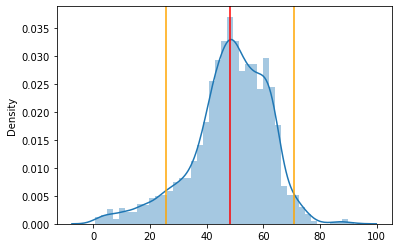

In [43]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.distplot(data_espana)
mean = data_nn.mean()['value']
std = data_nn.std()['value']
plt.axvline(x=mean, color='r', linestyle='-', label="\mu: {0:.2f}%".format(mean))
plt.axvline(x=mean+2*std, color='orange', linestyle='-')
plt.axvline(x=mean-2*std, color='orange', linestyle='-')
plt.show()


In [50]:
data_nn = data_nn.resample('d').mean()

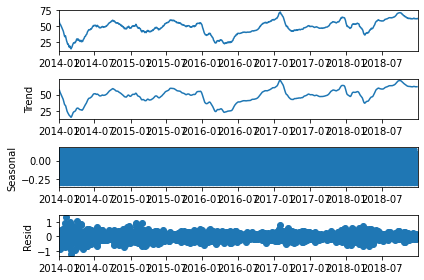

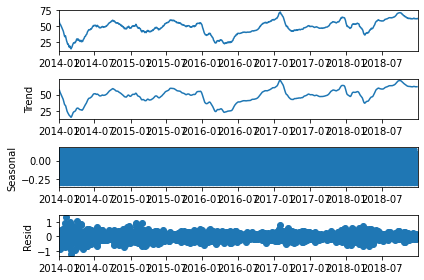

In [51]:
seasonal_decompose(data_nn).plot()

In [63]:
size_t = data_nn.shape[0]
size = int(size_t*0.75)
diff = size_t-size

<AxesSubplot:>

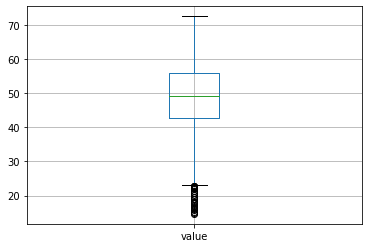

In [86]:
data_nn.boxplot()

<AxesSubplot:>

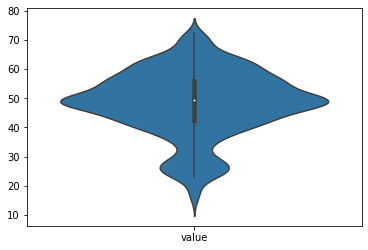

In [87]:
sns.violinplot(data_nn)

In [88]:
#removing outlier 
q1,q3 = data_nn.quantile([0.25, .75])['value']
IQR = q3-q1
upper_bound = q3 + 1.5 * IQR
lower_bound = q1- 1.5 * IQR
upper_bound,lower_bound
data_nn[data_nn.value>upper_bound] = data_nn.value.mean()
data_nn[data_nn.value<lower_bound] = data_nn.value.mean()


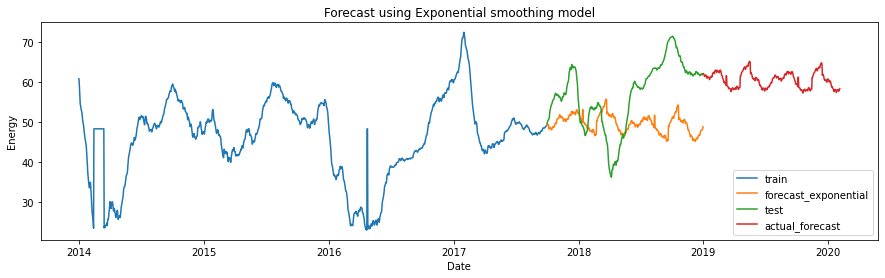

In [143]:
d1 = ExponentialSmoothing(data_nn.iloc[:size], trend='add',seasonal='add',seasonal_periods=210).fit()
final_forecast = pd.DataFrame(d1.forecast(diff)).rename(columns={0:'value'})

fig, ax = plt.subplots()
fig.set_size_inches(15, 4)
plt.xlabel('Date')
plt.title('Forecast using Exponential smoothing model')
plt.ylabel('Energy')
line1, = ax.plot(data_nn.iloc[:size], label='train')
line2, = ax.plot(final_forecast, label='forecast_exponential')
line3, = ax.plot(data_nn.iloc[size:], label='test')
moving_avg = data_nn.rolling(window=30).mean().shift(size-30)
moving_avg.dropna(inplace=True)
# line4, = ax.plot(moving_avg, label='moving_average')
naive_d = data_nn.shift(size)
d1 = ExponentialSmoothing(data_nn, trend='add',seasonal='add',seasonal_periods=210).fit()
forecast = pd.DataFrame(d1.forecast(400)).rename(columns={0:'value'})
line5, = ax.plot(forecast, label='actual_forecast')
ax.legend(handles=[line1, line2, line3,line5])

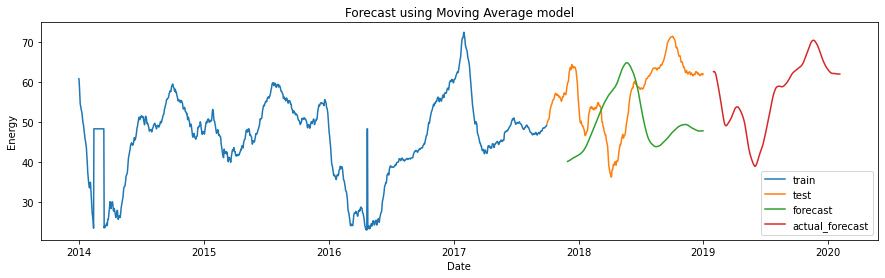

In [141]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 4)
plt.xlabel('Date')
plt.title('Forecast using Moving Average model')
plt.ylabel('Energy')
line1, = ax.plot(data_nn.iloc[:size], label='train')
line3, = ax.plot(data_nn.iloc[size:], label='test')
moving_avg = data_nn[size-diff:].rolling(window=60).mean()[60:].shift(diff).dropna()
line4, = ax.plot(moving_avg, label='forecast')
naive_d = data_nn.shift(size)
moving_avg_f = data_nn[size_t-400:].rolling(window=30).mean()[30:].shift(periods=400, freq='d')
line5, = ax.plot(moving_avg_f, label='actual_forecast')
ax.legend(handles=[line1,line3, line4 ,line5])

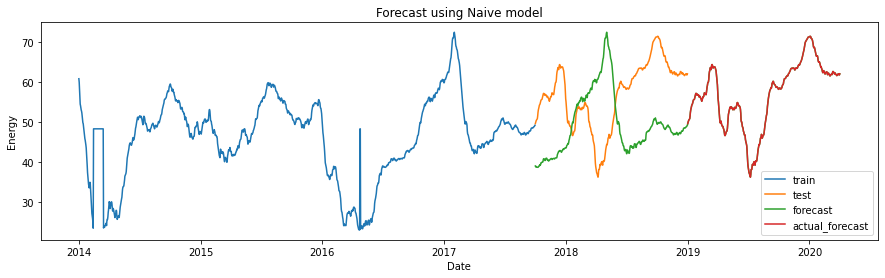

In [140]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 4)
plt.xlabel('Date')
plt.title('Forecast using Naive model')
plt.ylabel('Energy')

line1, = ax.plot(data_nn.iloc[:size], label='train')
line3, = ax.plot(data_nn.iloc[size:], label='test')
moving_avg = data_nn[size-diff:].shift(diff,freq='d')
line4, = ax.plot(moving_avg, label='forecast')
naive_d = data_nn[size:].shift(size)
moving_avg_f = data_nn[size:].shift(periods=diff, freq='d')
line5, = ax.plot(moving_avg_f, label='actual_forecast')
ax.legend(handles=[line1,line3, line4 ,line5])

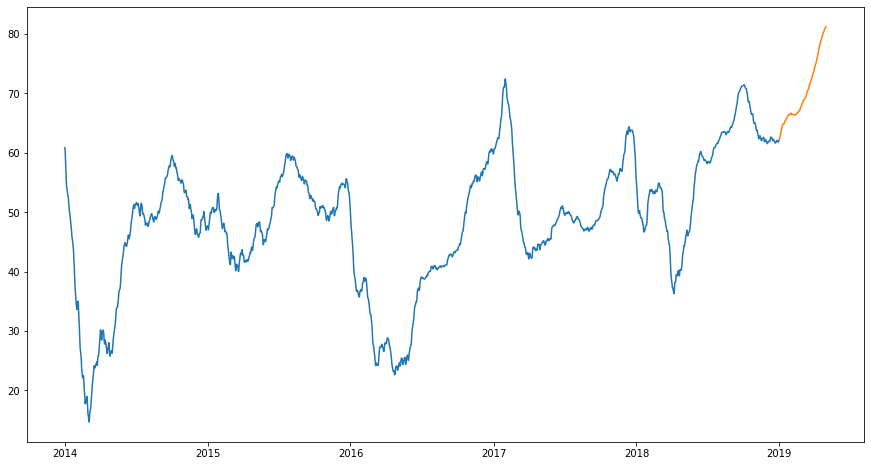

In [81]:

d1 = ExponentialSmoothing(data_nn, trend='add',seasonal='add',seasonal_periods=120).fit()
final_forecast = pd.DataFrame(d1.forecast(120)).rename(columns={0:'value'})
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
line1, = ax.plot(data_nn, label='past')
line2, = ax.plot(final_forecast, label='forecast')

In [ ]:
d1 = ExponentialSmoothing(data_nn, trend='add',seasonal='add',seasonal_periods=180).fit()
final_forecast = pd.DataFrame(d1.forecast(80)).rename(columns={0:'value'})
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
line1, = ax.plot(data_nn, label='past')
line2, = ax.plot(final_forecast, label='forecast')